In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
x_train_raw = pd.read_csv('data/data_reviews/x_train.csv')
y_train_raw = pd.read_csv('data/data_reviews/y_train.csv')
x_test_raw = pd.read_csv('data/data_reviews/x_test.csv')
x_train_raw.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


In [70]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import string
from contractions import contractions
def remove_punctuation(text):
    s = text.translate(str.maketrans('', '', string.punctuation))
    removed_numbers = re.sub("\S*\d\S*", "", s).strip()
    return removed_numbers

def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed

def text_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return lemmatized_output

from spellchecker import SpellChecker

spell = SpellChecker()

def xstr(s):
    return ['' if v is None else v for v in s]

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    # print(corrected_text)
    return " ".join(xstr(corrected_text))
        
def make_lowercase(text):
    lowered_output = ' '.join([w.lower() for w in text.split()])
    return lowered_output

def remove_proper_nouns(text):
    tagged_sentence = nltk.tag.pos_tag(text.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS' and tag!= 'PRON']
    edited_text = ' '.join(w for w in edited_sentence)
    return edited_text

def expand_contractions(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
    return text

stop_words = stopwords.words('english')
def remove_stopwords(text):
    edited_text = ' '.join(w for w in text.split() if w not in stop_words)
    return edited_text

def clean_reviews_fn(reviews):
#     reviews = x_train_raw['text'].values
    clean_reviews = []
    for r in reviews:
        lowercase_review = make_lowercase(r)
        remove_punc = remove_punctuation(lowercase_review)
        # remove_stop = remove_stopwords(remove_punc)
        lemmatize_review = text_lemmatization(remove_punc)
        spell_review = correct_spellings(lemmatize_review)
        clean_reviews.append(spell_review)
    
    return clean_reviews

In [71]:
x_train_cleaned = clean_reviews_fn(x_train_raw['text'].values)
x_test_cleaned = clean_reviews_fn(x_test_raw['text'].values)

In [73]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, GlobalMaxPool1D
from sklearn.model_selection import train_test_split

In [74]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
def create_NN_model(vocab_size,maxlen):
    embedding_dim = 50
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [75]:
df_tr_cleaned = pd.DataFrame (x_train_cleaned, columns = ['text'])
df_te_cleaned = pd.DataFrame (x_test_cleaned, columns = ['text'])

In [77]:
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

cv = KFold(n_splits=10, random_state=1, shuffle=True)

scores = []
tr_scores = []
kfold = cv.split(x_train_cleaned, y_train_raw['is_positive_sentiment'].values)
for k, (train, test) in enumerate(kfold):

    sentences_train = df_tr_cleaned.iloc[train, :]['text']
    sentences_test = df_tr_cleaned.iloc[test, :]['text']

    labels_train = y_train_raw.iloc[train,:]['is_positive_sentiment']
    labels_test = y_train_raw.iloc[test,:]['is_positive_sentiment']

    tokenizer = Tokenizer(num_words=5000,)
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size = len(tokenizer.word_index)+1

    maxlen = 65
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)

    model = create_NN_model_with_optimizer(vocab_size,maxlen,lr=1E-3)
    history = model.fit(X_train, labels_train,
                    epochs=50,
                    verbose=0,
                    validation_data=(X_test, labels_test),
                    batch_size=100)

    loss, tr_accuracy = model.evaluate(X_train, labels_train, verbose=False)
    # print("Training Accuracy: {:.4f}".format(accuracy))
    loss, te_accuracy = model.evaluate(X_test, labels_test, verbose=False)
    # print("Testing Accuracy:  {:.4f}".format(accuracy))

    scores.append(1-tr_accuracy)
    tr_scores.append(1-te_accuracy)
# print('Fold (%d) Cross-Validation accuracy: %.3f +/- %.3f' %(k,1-np.mean(tr_scores), 1-np.std(tr_scores)))
    # print('Fold: %2d, Training/Test Split Distribution: %s, Train Error Rate: %.3f,Test Error Rate: %.3f' % (k+1, np.bincount(y_train_raw['is_positive_sentiment'].iloc[train]), 1-tr_accuracy,1-te_accuracy))

print('10-Fold Cross-Validation Avg. Error Rate: %.3f +/- %.3f' %(np.mean(tr_scores), np.std(tr_scores)))


10-Fold Cross-Validation Avg. Error Rate: 0.183 +/- 0.024


In [62]:
sentences_train, sentences_test, labels_train, labels_test = train_test_split(df_tr_cleaned['text'],y_train_raw['is_positive_sentiment'], test_size = 0.2, random_state = 42)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1
maxlen = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)

model = create_NN_model_with_optimizer(vocab_size,maxlen,lr=1E-3)

In [63]:
history = model.fit(X_train, labels_train,
                    epochs=50,
                    verbose=0,
                    validation_data=(X_test, labels_test),
                    batch_size=100)

In [64]:
predict_proba = model.predict(X_test)
predictions = (predict_proba > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix,accuracy_score
print('After 80-20 split of Training Data')
print('Error Rate on Test Data:%.3f'% (1-accuracy_score(labels_test,predictions.flatten())))
print('CONFUSION MATRIX')
cm = confusion_matrix(labels_test,predictions.flatten())
cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
print(cm_df)

15/15 [==============================] - 0s 2ms/step
After 80-20 split of Training Data
Error Rate on Test Data:0.213
CONFUSION MATRIX
Predicted    0    1
True               
0          183   54
1           48  195


In [78]:
sentences_test = df_te_cleaned['text']
X_test = tokenizer.texts_to_sequences(sentences_test)
X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)
y_predict = model.predict(X_test)

yproba1_test = y_predict.flatten()
np.savetxt('yproba1_test.txt', yproba1_test)

19/19 [==============================] - 0s 1ms/step


In [72]:
print('Positive Review Misclassified as Negative\n\n')
for p,r,s in zip(predictions.flatten(),labels_test,sentences_test):
    if p!=r and p==0:
        print(s)

Positive Review Misclassified as Negative


highly recommended age although younger set probably appreciate subtle reference certainly appreciate one galley scene particular
advise look
def coming back bowl next time
place
convenient simple use get job done make car ride much smoother
someone shouldve invented sooner
performed
rare filmmaker take time tell worthy moral tale care love doesn't fall trap overly syrupy indulgent
recommend go anyone different brand cell player family
last night second time dining happy decided go back
get job done
happy complaint one regarding sound quality end
want healthy authentic ethic food try place
never forget
film sole bright spot jonah hill look almost unrecognizable fan recent superb due amount weight lost interim
sad movie good
battery working well replacement original came phone year ago
simple use like
good thing waiter helpful kept bloody mary coming
would casted role ready script
anyone right mind ask anything movie
use smallest earpiece prov

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(list(range(1,11)), scores,label='Train',marker='o')
ax.plot(list(range(1,11)),tr_scores,label='Test',marker='o')
# ax.plot(alpha_vals, test_error_avg, label='Test')
# ax.set_xscale('log')
ax.set_xticks(list(range(1,11)))
ax.set_title('Effect of 10-Fold Cross Validation on Error Rate', fontweight ="bold")
ax.set_xlabel('Fold')
ax.set_ylabel('Error Rate')
# ax.grid(which='major')
ax.legend(loc='center right')

In [9]:
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

for e in epochs:
    print('No.of Epochs: %d'%e)
    for b in batch_size:
        cv = KFold(n_splits=10, random_state=1, shuffle=True)
        scores = []
        tr_scores = []
        kfold = cv.split(x_train_cleaned, y_train_raw['is_positive_sentiment'].values)
        for k, (train, test) in enumerate(kfold):

            sentences_train = df_tr_cleaned.iloc[train, :]['text']
            sentences_test = df_tr_cleaned.iloc[test, :]['text']

            labels_train = y_train_raw.iloc[train,:]['is_positive_sentiment']
            labels_test = y_train_raw.iloc[test,:]['is_positive_sentiment']

            tokenizer = Tokenizer(num_words=5000)
            tokenizer.fit_on_texts(sentences_train)

            X_train = tokenizer.texts_to_sequences(sentences_train)
            X_test = tokenizer.texts_to_sequences(sentences_test)

            vocab_size = len(tokenizer.word_index)+1

            maxlen = 50
            X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
            X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)

            model = create_NN_model(vocab_size,maxlen)
            history = model.fit(X_train, labels_train,
                            epochs=e,
                            verbose=0,
                            validation_data=(X_test, labels_test),
                            batch_size=b)

            loss, tr_accuracy = model.evaluate(X_train, labels_train, verbose=False)
            # print("Training Accuracy: {:.4f}".format(accuracy))
            loss, te_accuracy = model.evaluate(X_test, labels_test, verbose=False)
            # print("Testing Accuracy:  {:.4f}".format(accuracy))

            scores.append(1-tr_accuracy)
            tr_scores.append(1-te_accuracy)
        print('Batch Size (%d) 10-Fold Cross-Validation Avg Error Rate: %.3f +/- %.3f' %(b,np.mean(tr_scores), np.std(tr_scores)))
            # print('Fold: %2d, Training/Test Split Distribution: %s, Train Accuracy: %.3f,Test Accuracy: %.3f' % (k+1, np.bincount(y_train_raw['is_positive_sentiment'].iloc[train]), tr_accuracy,te_accuracy))

# print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(tr_scores), np.std(tr_scores)))
    

No.of Epochs: 10
Batch Size (10) 10-Fold Cross-Validation Avg Error Rate: 0.184 +/- 0.019
Batch Size (20) 10-Fold Cross-Validation Avg Error Rate: 0.176 +/- 0.021
Batch Size (40) 10-Fold Cross-Validation Avg Error Rate: 0.172 +/- 0.021
Batch Size (60) 10-Fold Cross-Validation Avg Error Rate: 0.170 +/- 0.017
Batch Size (80) 10-Fold Cross-Validation Avg Error Rate: 0.168 +/- 0.016
Batch Size (100) 10-Fold Cross-Validation Avg Error Rate: 0.166 +/- 0.016
No.of Epochs: 50
Batch Size (10) 10-Fold Cross-Validation Avg Error Rate: 0.193 +/- 0.021
Batch Size (20) 10-Fold Cross-Validation Avg Error Rate: 0.188 +/- 0.017
Batch Size (40) 10-Fold Cross-Validation Avg Error Rate: 0.188 +/- 0.014
Batch Size (60) 10-Fold Cross-Validation Avg Error Rate: 0.181 +/- 0.026
Batch Size (80) 10-Fold Cross-Validation Avg Error Rate: 0.178 +/- 0.016
Batch Size (100) 10-Fold Cross-Validation Avg Error Rate: 0.183 +/- 0.018
No.of Epochs: 100
Batch Size (10) 10-Fold Cross-Validation Avg Error Rate: 0.200 +/- 0.0

In [14]:
def create_NN_model_with_optimizer(vocab_size,maxlen,lr):
    embedding_dim = 50
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [13]:
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.optimizers import Adam

def create_NN_model_with_optimizer(vocab_size,maxlen,lr):
    embedding_dim = 50
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
optimizers = ['adam','RMSprop','sgd','Adamax','Ftrl']
tr_reg_er = []
te_reg_er = []
fig = plt.figure(figsize=(15,15))
for o in range(len(optimizers)):
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = []
    tr_scores = []
    kfold = cv.split(x_train_cleaned, y_train_raw['is_positive_sentiment'].values)
    for k, (train, test) in enumerate(kfold):
        if k == 1:
            sentences_train = df_tr_cleaned.iloc[train, :]['text']
            sentences_test = df_tr_cleaned.iloc[test, :]['text']

            labels_train = y_train_raw.iloc[train,:]['is_positive_sentiment']
            labels_test = y_train_raw.iloc[test,:]['is_positive_sentiment']

            tokenizer = Tokenizer(num_words=5000)
            tokenizer.fit_on_texts(sentences_train)

            X_train = tokenizer.texts_to_sequences(sentences_train)
            X_test = tokenizer.texts_to_sequences(sentences_test)

            vocab_size = len(tokenizer.word_index)+1

            maxlen = 65
            X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
            X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)

            model = create_NN_model_with_optimizer(vocab_size,maxlen,optimizers[o])
            history = model.fit(X_train, labels_train,
                            epochs=20,
                            verbose=0,
                            validation_data=(X_test, labels_test),
                            batch_size=100)
            plt.plot(history.history['accuracy'], label='Train')
            plt.plot(history.history['val_accuracy'], label='Test')
            # plt.title('Learning Rate:'+str(learning_rates[i])+' Test Accuracy:%.3f'%(te_accuracy))
            loss, tr_accuracy = model.evaluate(X_train, labels_train, verbose=False)
            # print("Training Accuracy: {:.4f}".format(accuracy))
            loss, te_accuracy = model.evaluate(X_test, labels_test, verbose=False)
            # print("Testing Accuracy:  {:.4f}".format(accuracy))
            plot_no = 420 + (i+1)
            plt.legend(loc='upper left')
            plt.subplot(plot_no)

            scores.append(1-tr_accuracy)
            tr_scores.append(1-te_accuracy)
    # print('Optimizer (%s) Avg 10-Fold Cross-Validation Error Rate: %.3f +/- %.3f' %(optimizers[o],np.mean(tr_scores), np.std(tr_scores)))
    tr_reg_er.append(np.mean(scores))
    te_reg_er.append(np.mean(tr_scores))
plt.show()        

Optimizer (adam) Avg 10-Fold Cross-Validation Error Rate: 0.150 +/- 0.000
Optimizer (RMSprop) Avg 10-Fold Cross-Validation Error Rate: 0.163 +/- 0.000
Optimizer (sgd) Avg 10-Fold Cross-Validation Error Rate: 0.471 +/- 0.000
Optimizer (Adamax) Avg 10-Fold Cross-Validation Error Rate: 0.217 +/- 0.000
Optimizer (Ftrl) Avg 10-Fold Cross-Validation Error Rate: 0.546 +/- 0.000


<Figure size 1080x1080 with 0 Axes>

In [39]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 100, 50)           184050    
                                                                 
 global_max_pooling1d_29 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_88 (Dense)            (None, 10)                510       
                                                                 
 dense_89 (Dense)            (None, 1)                 11        
                                                                 
Total params: 184,571
Trainable params: 184,571
Non-trainable params: 0
_________________________________________________________________


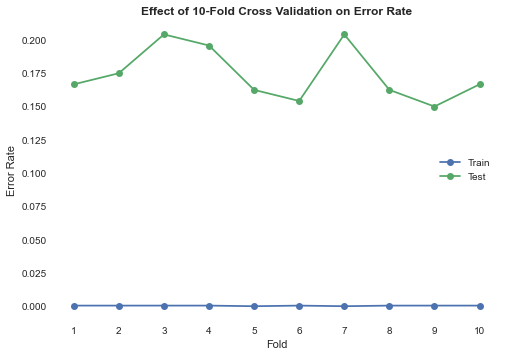

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn') #
sns.set_style('white')
fig = plt.figure()
ax = plt.axes()
ax.plot(list(range(1,11)), [1-x for x in scores],label='Train',marker='o')
ax.plot(list(range(1,11)), [1-x for x in tr_scores],label='Test',marker='o')
# ax.plot(alpha_vals, test_error_avg, label='Test')
# ax.set_xscale('log')
ax.set_xticks(list(range(1,11)))
ax.set_title('Effect of 10-Fold Cross Validation on Error Rate', fontweight ="bold")
ax.set_xlabel('Fold')
ax.set_ylabel('Error Rate')
# ax.grid(which='major')
ax.legend(loc='center right')

In [46]:
print('10-Fold Cross Validation (Sequential Neural Network)')
print('Avg. Training Error Rate: %.3f'%(1-np.mean(scores)))
print('Avg. Testing Error Rate: %.3f'%(1-np.mean(tr_scores)))

10-Fold Cross Validation (Sequential Neural Network)
Avg. Training Error Rate: 0.000
Avg. Testing Error Rate: 0.174


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D

In [12]:
sentences_test = x_test_cleaned
X_test = tokenizer.texts_to_sequences(df_te_cleaned['text'])
X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)
y_predict = model.predict(X_test)

19/19 [==============================] - 0s 1ms/step


In [13]:
yproba1_test = y_predict.flatten()
np.savetxt('yproba1_test.txt', yproba1_test)

In [14]:
len(yproba1_test)

600

In [15]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 50)            184050    
                                                                 
 global_max_pooling1d_9 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 184,571
Trainable params: 184,571
Non-trainable params: 0
_________________________________________________________________


## Another Implementation

In [17]:
df_tr_cleaned['total_words'] = df_tr_cleaned['text'].str.count(' ') + 1

#prints the dataframe at the index of it's longest review
print(df_tr_cleaned.loc[df_tr_cleaned.total_words.idxmax()])

#prints the length of the longest view in the dataset
print("\nThe longest comment is " + str(df_tr_cleaned['total_words'].max()) + " words.\n")

text           i have to mention this and it is a huge spoile...
total_words                                                   61
Name: 1356, dtype: object

The longest comment is 61 words.



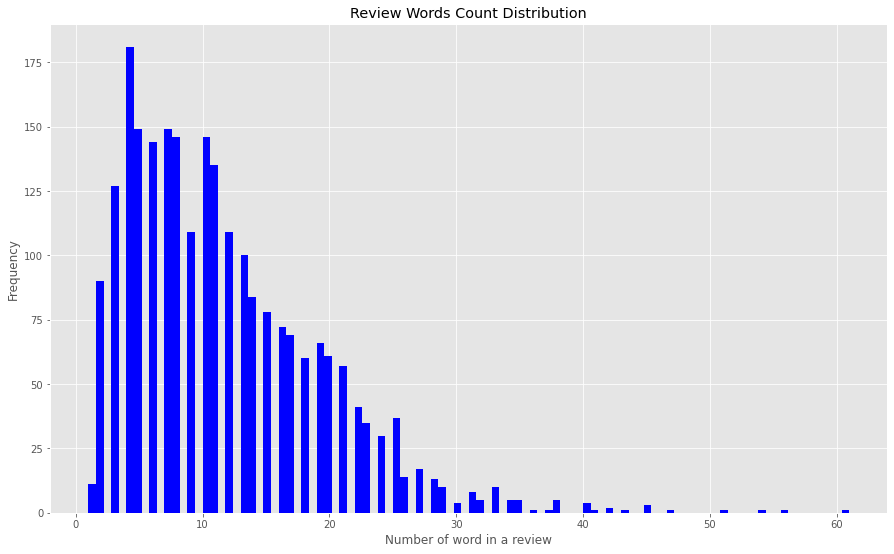

In [19]:
# plot word frequency

plt.figure(figsize=(15, 9))
plt.hist([(df_tr_cleaned['total_words'])],bins=100,color = "blue")
plt.xlabel('Number of word in a review')
plt.ylabel('Frequency')
plt.title('Review Words Count Distribution')
plt.show()

C:\Users\Priyanshi_code\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


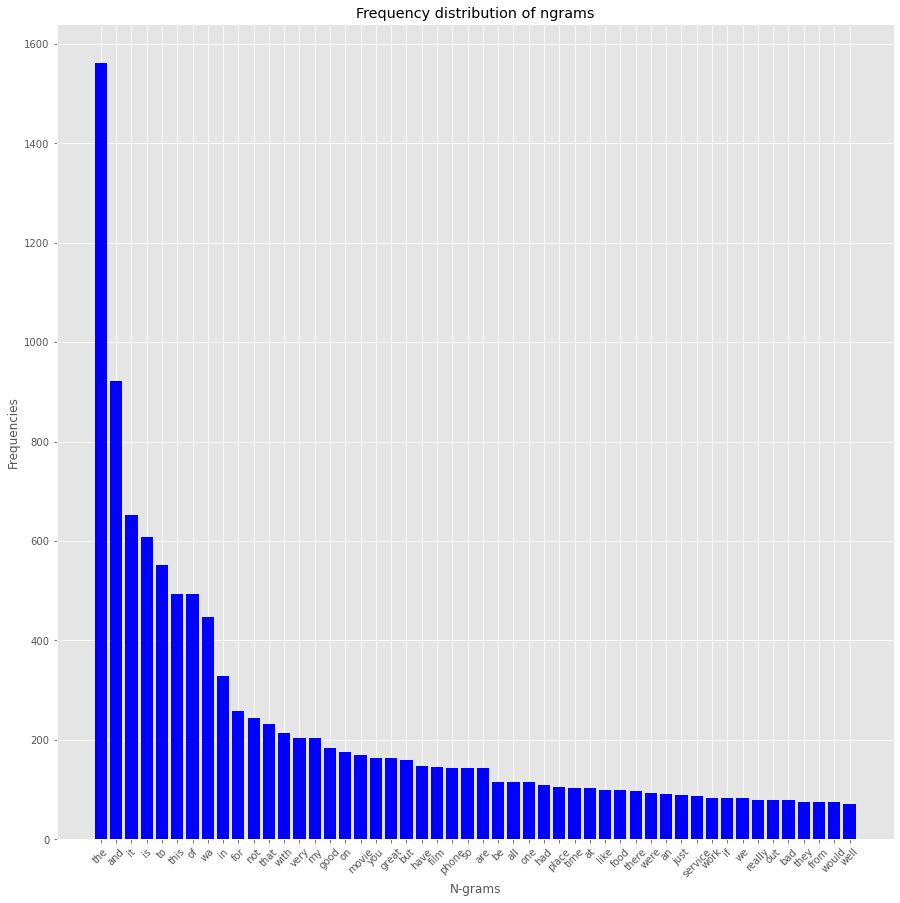

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# transform and vectorize the comments in a sparse matrix. The dimenion length is the number of instances, the width of the matrix is the
# number of words in total corpse. The words that are not in the each review is padded with 0, hence the sparse matrix.

vect_texts = vectorizer.fit_transform(list(df_tr_cleaned['text']))
all_ngrams = vectorizer.get_feature_names()

# display top min(50,len(all_ngrams) of the most frequent words
num_ngrams = min(50, len(all_ngrams))

# count the number of words in the total corpse
all_counts = vect_texts.sum(axis=0).tolist()[0]

# loop the words(features) with counts using zip function
all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])

ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(15, 15))
plt.bar(idx, counts, width=0.8, color = "blue")
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

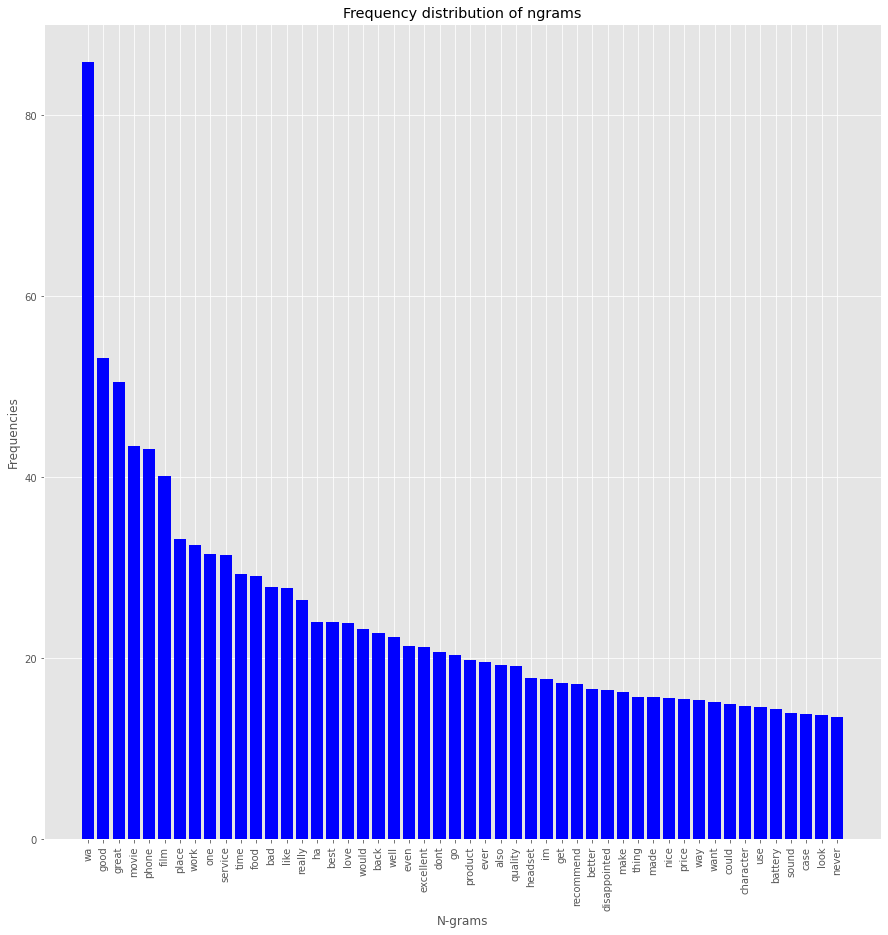

In [21]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

# import a list of stopwords, when applied the stopwords in the corpose will not be tokenized, they will be skipped
stopwords=stopwords.words('english')

# min_df=2, any words that occurs less than 2 times in the total corpse will not be tokenized

vectorizer = TfidfVectorizer(min_df=3, binary=True, analyzer='word',ngram_range= (1,2), stop_words=stopwords)
df_bigram = vectorizer.fit_transform(df_tr_cleaned['text'])

all_ngrams = vectorizer.get_feature_names()

# display top min(50,len(all_ngrams) of the most frequent words
num_ngrams = min(50, len(all_ngrams))

# count the number of words in the total corpse
all_counts = df_bigram.sum(axis=0).tolist()[0]

# loop the words(features) with counts using zip function
all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])

ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(15, 15))
plt.bar(idx, counts, width=0.8, color = "blue")
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=90)
plt.show()

In [22]:
k=26000

selector = SelectKBest(chi2, k=min(k, df_bigram.shape[1]))
selector.fit(df_bigram, y_train_raw['is_positive_sentiment'])
transformed_texts = selector.transform(df_bigram).astype('float32')

In [23]:
transformed_texts=transformed_texts.toarray()

In [24]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers

cv = KFold(n_splits=10, random_state=1, shuffle=True)
kfold = cv.split(transformed_texts, y_train_raw['is_positive_sentiment'].values)
scores = []
tr_scores = []
for k, (train, test) in enumerate(kfold):
    
    sentences_train = transformed_texts[train, :]
    sentences_test = transformed_texts[test, :]
    
    labels_train = y_train_raw.iloc[train,:]['is_positive_sentiment']
    labels_test = y_train_raw.iloc[test,:]['is_positive_sentiment']
    
    mf=26000
    max_features = min(mf, df_bigram.shape[1])
    
    model = Sequential()
    model.add(Dense(64, input_dim=max_features, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy',
                  optimizer='RMSprop',
                  metrics=['acc'])
    
    
    history = model.fit([sentences_train], labels_train,
                    epochs=50,
                    verbose=0,
                    validation_data=([sentences_test], labels_test),
                    batch_size=100)
    
    loss, tr_accuracy = model.evaluate([sentences_train], labels_train, verbose=False)
    # print("Training Accuracy: {:.4f}".format(accuracy))
    loss, te_accuracy = model.evaluate([sentences_test], labels_test, verbose=False)
    # print("Testing Accuracy:  {:.4f}".format(accuracy))

    scores.append(tr_accuracy)
    tr_scores.append(te_accuracy)
    print('Fold: %2d, Training/Test Split Distribution: %s, Train Accuracy: %.3f,Test Accuracy: %.3f' % (k+1, np.bincount(y_train_raw['is_positive_sentiment'].iloc[train]), tr_accuracy,te_accuracy))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [1080 1080], Train Accuracy: 0.988,Test Accuracy: 0.775
Fold:  2, Training/Test Split Distribution: [1091 1069], Train Accuracy: 0.987,Test Accuracy: 0.800
Fold:  3, Training/Test Split Distribution: [1078 1082], Train Accuracy: 0.987,Test Accuracy: 0.779
Fold:  4, Training/Test Split Distribution: [1086 1074], Train Accuracy: 0.989,Test Accuracy: 0.771
Fold:  5, Training/Test Split Distribution: [1085 1075], Train Accuracy: 0.989,Test Accuracy: 0.842
Fold:  6, Training/Test Split Distribution: [1075 1085], Train Accuracy: 0.989,Test Accuracy: 0.821
Fold:  7, Training/Test Split Distribution: [1084 1076], Train Accuracy: 0.989,Test Accuracy: 0.779
Fold:  8, Training/Test Split Distribution: [1070 1090], Train Accuracy: 0.988,Test Accuracy: 0.783
Fold:  9, Training/Test Split Distribution: [1068 1092], Train Accuracy: 0.989,Test Accuracy: 0.767
Fold: 10, Training/Test Split Distribution: [1083 1077], Train Accuracy: 0.987,Test Accuracy: 0.800


In [25]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 64)                83072     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 87,297
Trainable params: 87,297
Non-trainable params: 0
_________________________________________________________________


In [27]:
test_bigram = vectorizer.transform(df_te_cleaned['text'])
test_transformed_texts = selector.transform(test_bigram).astype('float32')
y_predict = model.predict(test_transformed_texts)

19/19 [==============================] - 0s 2ms/step


In [28]:
yproba1_test = y_predict.flatten()
np.savetxt('yproba1_test.txt', yproba1_test)

## LSTM Implementation

In [ ]:
import re
import nltk
def remove_tags(string):
    removelist = ""
    result = re.sub('','',string)          #remove HTML tags
    result = re.sub('https://.*','',result)   #remove URLs
    result = result.lower()
    return result
x_train_raw['text']=x_train_raw['text'].apply(lambda cw : remove_tags(cw))
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
x_train_raw['text'] = x_train_raw['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
x_train_raw['text'] = x_train_raw.text.apply(lemmatize_text)

In [ ]:
s = 0.0
for i in x_train_raw['text']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/x_train_raw.shape[0])

In [ ]:
reviews = x_train_raw['text'].values
labels = y_train_raw['is_positive_sentiment'].values
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, labels)

In [ ]:
# Hyperparameters of the model
vocab_size = 5000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 100 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [ ]:
import keras
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
#     keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

In [ ]:
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.25)

## Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Embedding, Flatten, GlobalMaxPool1D

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

print('Running grid search for data set')
sentences = x_train_raw['text'].values
y = y_train_raw['is_positive_sentiment'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=100,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

test_accuracy = grid.score(X_test, y_test)

s = ('Running data set\nBest Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
    grid_result.best_score_,
    grid_result.best_params_,
    test_accuracy)
print(output_string)